In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import itertools
import cv2 as cv
import h5py

Paths are for dataset tagged: all


In [55]:
# read through each metadata file and fix framestamp rollover
metadata_file = glob.glob(os.path.join(paths['raw_data'],'*.csv'))
print(metadata_file)

numFrames = np.zeros(len(metadata_file))
time = []
framestamp = []
Frames = []
for i in range(len(metadata_file)):
    metadata = pd.read_csv(metadata_file[i])
    numFrames[i] = len(metadata.Width)
    numFrames[i] = numFrames[i].astype(int)
    timestamp = metadata.CameraTimestampSeconds + 10**-6*metadata.CameraTimestampMicroSeconds
    time.append(timestamp)

    framestamp = metadata.Framestamp
    framestamp = np.array(framestamp)
    bitmax = np.where(framestamp == 65535)
    if len(bitmax[0]) == 1:
        cut = framestamp[bitmax[0][0]+1:-1]
        newcut = cut + 65535
        Frames.append(np.concatenate((framestamp[0:bitmax[0][0]],newcut)))
    elif len(bitmax[0]) > 1:
        temp = []
        temp.append(np.array(framestamp[0:bitmax[0][0]]))
        for j in range(len(bitmax[0])-1):
            cut = temp[j][-1] + framestamp[bitmax[0][j]+1:bitmax[0][j+1]]
            temp.append(cut)
        temp.append(temp[j+1][-1] + framestamp[bitmax[0][-1]+1:-1])
        Frames.append(np.concatenate(temp))
    elif len(bitmax[0]) == 0:
        Frames.append(framestamp[0:-1])

width = metadata.Width[0]
print(width)
Xoffset = metadata.XOffset[0]
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.YOffset[0]
print(Yoffset)

['C:\\AIND\\output_data\\BigTiffs2023-07-19T11_41_07.3182208-07_00\\session_params_2023-07-19T11_41_07.csv', 'C:\\AIND\\output_data\\BigTiffs2023-07-19T11_41_07.3182208-07_00\\session_params_2023-07-19T12_05_44.csv']
1700
212
224
556


In [3]:
# Unskew image, rotation followed by affine transformation

# Read from calibration.txt
with open('calibration.txt', 'r') as f:
    for line in f:
        name, value = line.strip().split(' = ')
        exec(f'{name} = {value}')

# Read from above txt file after running preprocess_01_unskewimage
theta_r = rot_tform_thetaR
pt1 = [aff_tform_pt1[0]-Xoffset, aff_tform_pt1[1]-Yoffset] 
pt2 = [aff_tform_pt2[0]-Xoffset, aff_tform_pt2[1]-Yoffset] 
pt3 = [aff_tform_pt3[0]-Xoffset, aff_tform_pt3[1]-Yoffset] 
pt4 = [aff_tform_pt4[0]-Xoffset, aff_tform_pt4[1]-Yoffset] 
pt5 = [aff_tform_pt5[0]-Xoffset, aff_tform_pt5[1]-Yoffset] 
pt6 = [aff_tform_pt6[0]-Xoffset, aff_tform_pt6[1]-Yoffset]
fiber1_location = [fiber1_pixels[1]-Yoffset,fiber1_pixels[0]-Yoffset]
fiber2_location = [fiber2_pixels[1]-Yoffset,fiber2_pixels[0]-Yoffset]

# Create rotation and affine transformation matrix
rows,cols = [height, width]
M1 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M2 = cv.getAffineTransform(pts1,pts2)

In [15]:
# Get all Tiff directories
files = os.listdir(paths['raw_data'])
print(files)
folders = []
for entry in os.scandir(paths['raw_data']):
    if entry.is_dir():
        folders.append(entry.name)
folders = natsorted(folders)
print(folders)

# Read through each Tiff directory, exrtact tiff files, and unskew images
fiber1 = []
fiber2 = []
peaks = []
for i in range(len(folders)):
    print(folders[i])
    files = os.listdir(os.path.join(paths['raw_data'],folders[i]))
    files = natsorted(files)
    num_files = np.size(files,0)
    tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[0])
    temp = io.imread(tiff_file_path).astype(float)
    num = int(''.join(filter(str.isdigit, files[-1])))
    sz_x = 1000*(num-1) + temp.shape[0]
    sz_y = width
    tempfiber1 = np.zeros([sz_x, sz_y])
    tempfiber2 = np.zeros([sz_x, sz_y])
    peak = np.zeros(sz_x)
    #for j in range(round(len(Frames[i])/1000)):
    for j in range(num_files-1):
        print(files[j])
        # Extract the number in the filename and convert to integer
        num = int(''.join(filter(str.isdigit, files[j])))
        tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[j])
        temp = io.imread(tiff_file_path).astype(float)
        for frame in range(temp.shape[0]):
            temp_rotated = cv.warpAffine(temp[frame,:,:],M1,(cols,rows))
            img = cv.warpAffine(temp_rotated,M2,(cols,rows))
            fiber1_m = np.mean(img[fiber1_location[1]:fiber1_location[0],:],axis=0)
            fiber2_m = np.mean(img[fiber2_location[1]:fiber2_location[0],:],axis=0)
            
            temp_peak, _ = find_peaks(fiber1_m,height=200,distance=200)
            if len(temp_peak) > 1:
                max_peak = np.argmax(fiber1_m[temp_peak])
                temp_peak = temp_peak[max_peak]

            fiber1_m = np.expand_dims(fiber1_m, axis=0)
            fiber2_m = np.expand_dims(fiber2_m, axis=0)
            if j == 0:
                tempfiber1[frame,:] = fiber1_m
                tempfiber2[frame,:] = fiber2_m
                peak[frame] = temp_peak
            else:
                tempfiber1[num*1000 + frame,:] = fiber1_m
                tempfiber2[num*1000 + frame,:] = fiber2_m
                peak[num*1000 + frame] = temp_peak

    fiber1.append(tempfiber1)
    fiber2.append(tempfiber2)
    peaks.append(peak)


['faceCam_2023-07-19T11_40_10.avi', 'hsfp_rig.json', 'ophys_session.json', 'session_params_2023-07-19T11_41_07.csv', 'session_params_2023-07-19T12_05_44.csv', 'SS_674663_2023-07-19.json', 'Tiffs0', 'Tiffs1']
['Tiffs0', 'Tiffs1']
Tiffs0
Tiffs0.tif
Tiffs1.tif
Tiffs2.tif
Tiffs3.tif
Tiffs4.tif
Tiffs5.tif
Tiffs6.tif
Tiffs7.tif
Tiffs8.tif
Tiffs9.tif
Tiffs10.tif
Tiffs11.tif
Tiffs12.tif
Tiffs13.tif
Tiffs14.tif
Tiffs15.tif
Tiffs16.tif
Tiffs17.tif
Tiffs18.tif
Tiffs19.tif
Tiffs20.tif
Tiffs21.tif
Tiffs22.tif
Tiffs23.tif
Tiffs24.tif
Tiffs25.tif
Tiffs26.tif
Tiffs27.tif
Tiffs28.tif
Tiffs29.tif
Tiffs30.tif
Tiffs31.tif
Tiffs32.tif
Tiffs33.tif
Tiffs34.tif
Tiffs35.tif
Tiffs36.tif
Tiffs37.tif
Tiffs38.tif
Tiffs39.tif
Tiffs40.tif
Tiffs41.tif
Tiffs42.tif
Tiffs43.tif
Tiffs44.tif
Tiffs45.tif
Tiffs46.tif
Tiffs47.tif
Tiffs48.tif
Tiffs49.tif
Tiffs50.tif
Tiffs51.tif
Tiffs52.tif
Tiffs53.tif
Tiffs54.tif
Tiffs55.tif
Tiffs56.tif
Tiffs57.tif
Tiffs58.tif
Tiffs59.tif
Tiffs60.tif
Tiffs61.tif
Tiffs62.tif
Tiffs63.tif
Tiffs6

In [62]:
# Set order of lasers and interleave into individual laser channels

c = pd.read_hdf(paths['root']/'pixel_to_nm.hdf5', key='Camera_pixel', more='r')
w = pd.read_hdf(paths['root']/'pixel_to_nm.hdf5', key='Wavelength_nm', more='r')
wavelength = w.to_numpy()
camera_px = c.to_numpy()
lasers = [405,445,473,514,560]

laser_order = []
for i in range(len(peaks)):
    l_order = np.zeros(len(peaks[i]))
    for j in range(len(peaks[i])):
        laser_pix = min(camera_px, key=lambda x:abs(x-peaks[i][j]-Xoffset))
        camera_pix = np.where(camera_px>laser_pix)
        p = camera_pix[-1]
        p = p[-1]
        temp_laser = min(lasers, key=lambda x:abs(x-wavelength[p]))
        l_order[j] = temp_laser
    laser_order.append(l_order)
print(laser_order)

# Truncate tiffs extracted fiber 1 and fiber 2 data to match timestamps from csv
fiber1_trunc = []
fiber2_trunc = []
laser_order_trunc = []
for i in range(len(fiber1)):
    fiber1_trunc.append(fiber1[i][0:int(numFrames[i]),:])
    fiber2_trunc.append(fiber2[i][0:int(numFrames[i]),:])
    laser_order_trunc.append(laser_order[i][0:int(numFrames[i])])

[array([560., 405., 445., ..., 445., 473., 514.]), array([560., 405., 445., ..., 445., 473., 514.])]


In [73]:
# Interleave signals from each fiber into the five laser channels
L405_F1 = []
L445_F1 = []
L473_F1 = []
L514_F1 = []
L560_F1 = []
L405_F2 = []
L445_F2 = []
L473_F2 = []
L514_F2 = []
L560_F2 = []
time_405 = []

for i in range(len(Frames)):
    L405_idx = np.where(laser_order_trunc[i]==405)
    L405_idx = np.array(L405_idx[0])
    F1_405 = fiber1_trunc[i][L405_idx,:]
    F2_405 = fiber2_trunc[i][L405_idx,:]
    temptime_405 = np.array(time[i][L405_idx])
    L445_idx = np.where(laser_order_trunc[i]==445)
    L445_idx = np.array(L445_idx[0])
    F1_445 = fiber1_trunc[i][L445_idx,:]
    F2_445 = fiber2_trunc[i][L445_idx,:]
    L473_idx = np.where(laser_order_trunc[i]==473)
    L473_idx = np.array(L473_idx[0])
    F1_473 = fiber1_trunc[i][L473_idx,:]
    F2_473 = fiber2_trunc[i][L473_idx,:]
    L514_idx = np.where(laser_order_trunc[i]==514)
    L514_idx = np.array(L514_idx[0])
    F1_514 = fiber1_trunc[i][L514_idx,:]
    F2_514 = fiber2_trunc[i][L514_idx,:]
    L560_idx = np.where(laser_order_trunc[i]==560)
    L560_idx = np.array(L560_idx[0])
    F1_560 = fiber1_trunc[i][L560_idx,:]
    F2_560 = fiber2_trunc[i][L560_idx,:]
    
    L405_F1.append(F1_405)
    L445_F1.append(F1_445)
    L473_F1.append(F1_473)
    L514_F1.append(F1_514)
    L560_F1.append(F1_560)
    L405_F2.append(F2_405)
    L445_F2.append(F2_445)
    L473_F2.append(F2_473)
    L514_F2.append(F2_514)
    L560_F2.append(F2_560)
    time_405.append(temptime_405)


for i in range(len(Frames)):
    cut = np.min([len(L405_F1[i]),len(L445_F1[i]),len(L473_F1[i]),len(L514_F1[i]),len(L560_F1[i])])
    L405_F1[i] = L405_F1[i][0:cut,:]
    L445_F1[i] = L445_F1[i][0:cut,:]
    L473_F1[i] = L473_F1[i][0:cut,:]
    L514_F1[i] = L514_F1[i][0:cut,:]
    L560_F1[i] = L560_F1[i][0:cut,:]
    L405_F2[i] = L405_F2[i][0:cut,:]
    L445_F2[i] = L445_F2[i][0:cut,:]
    L473_F2[i] = L473_F2[i][0:cut,:]
    L514_F2[i] = L514_F2[i][0:cut,:]
    L560_F2[i] = L560_F2[i][0:cut,:]
    time_405[i] = time_405[i][0:cut]


In [85]:
# Concatenate signals from all frame folders into a single sequence
LCh405_F1 = np.concatenate(L405_F1)
LCh445_F1 = np.concatenate(L445_F1)
LCh473_F1 = np.concatenate(L473_F1)
LCh514_F1 = np.concatenate(L514_F1)
LCh560_F1 = np.concatenate(L560_F1)
LCh405_F2 = np.concatenate(L405_F2)
LCh445_F2 = np.concatenate(L445_F2)
LCh473_F2 = np.concatenate(L473_F2)
LCh514_F2 = np.concatenate(L514_F2)
LCh560_F2 = np.concatenate(L560_F2)
lasers = np.concatenate(laser_order_trunc)
timeseries_405 = np.concatenate(time_405)
norm_time = timeseries_405 - timeseries_405[0]
full_time = np.concatenate(time)

In [75]:
# Convert pixel data into wavelength data

LCh_405_F1 = np.zeros([LCh405_F1.shape[0], wavelength.shape[0]])
LCh_405_F2 = np.zeros([LCh405_F2.shape[0], wavelength.shape[0]])
LCh_445_F1 = np.zeros([LCh445_F1.shape[0], wavelength.shape[0]])
LCh_445_F2 = np.zeros([LCh445_F2.shape[0], wavelength.shape[0]])
LCh_473_F1 = np.zeros([LCh473_F1.shape[0], wavelength.shape[0]])
LCh_473_F2 = np.zeros([LCh473_F2.shape[0], wavelength.shape[0]])
LCh_514_F1 = np.zeros([LCh514_F1.shape[0], wavelength.shape[0]])
LCh_514_F2 = np.zeros([LCh514_F2.shape[0], wavelength.shape[0]])
LCh_560_F1 = np.zeros([LCh560_F1.shape[0], wavelength.shape[0]])
LCh_560_F2 = np.zeros([LCh560_F2.shape[0], wavelength.shape[0]])

for px in range(0,wavelength.shape[0]):
    LCh_405_F1[:,px] = LCh405_F1[:,camera_px[px]-Xoffset]
    LCh_405_F2[:,px] = LCh405_F2[:,camera_px[px]-Xoffset]
    LCh_445_F1[:,px] = LCh445_F1[:,camera_px[px]-Xoffset]
    LCh_445_F2[:,px] = LCh445_F2[:,camera_px[px]-Xoffset]
    LCh_473_F1[:,px] = LCh473_F1[:,camera_px[px]-Xoffset]
    LCh_473_F2[:,px] = LCh473_F2[:,camera_px[px]-Xoffset]
    LCh_514_F1[:,px] = LCh514_F1[:,camera_px[px]-Xoffset]
    LCh_514_F2[:,px] = LCh514_F2[:,camera_px[px]-Xoffset]
    LCh_560_F1[:,px] = LCh560_F1[:,camera_px[px]-Xoffset]
    LCh_560_F2[:,px] = LCh560_F2[:,camera_px[px]-Xoffset]
    

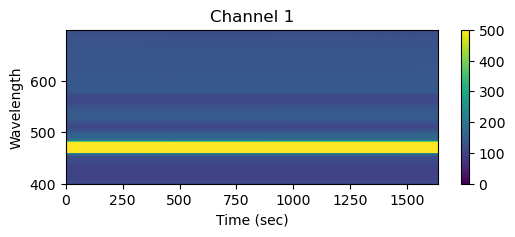

In [78]:
f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(LCh_473_F1), aspect='auto', vmin=0, vmax=500, extent=[np.min(norm_time), np.max(norm_time), 699, 400])
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='Channel 1', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

In [89]:
# Save preprocessed data in hdf5 file

data_preprocessed = {'Time':timeseries_405, 'Full_TimeStamps':full_time,'Lasers':lasers, 'Wavelength':wavelength, 
                        'Channel_405_F1':LCh_405_F1, 'Channel_445_F1':LCh_445_F1, 'Channel_473_F1':LCh_473_F1,
                        'Channel_514_F1':LCh_514_F1, 'Channel_560_F1':LCh_560_F1, 'Channel_405_F2':LCh_405_F2,
                        'Channel_445_F2':LCh_445_F2, 'Channel_473_F2':LCh_473_F2, 'Channel_514_F2':LCh_514_F2,
                        'Channel_560_F2':LCh_560_F2}
for key in data_preprocessed.keys():
    print(f'\n{key}')
    print(data_preprocessed[key])

# Write a new hdf5 file with all keys in data_preprocessed
hf = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','w')
for key in data_preprocessed.keys():
    hf.create_dataset(key, data = data_preprocessed[key])
hf.close()


Time
[1.68979207e+09 1.68979207e+09 1.68979207e+09 ... 1.68979371e+09
 1.68979371e+09 1.68979371e+09]

Full_TimeStamps
[1.68979207e+09 1.68979207e+09 1.68979207e+09 ... 1.68979371e+09
 1.68979371e+09 1.68979371e+09]

Lasers
[560. 405. 445. ... 560. 405. 445.]

Wavelength
[400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489
 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 5

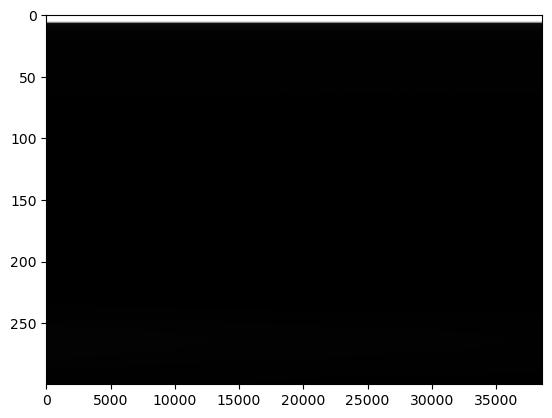

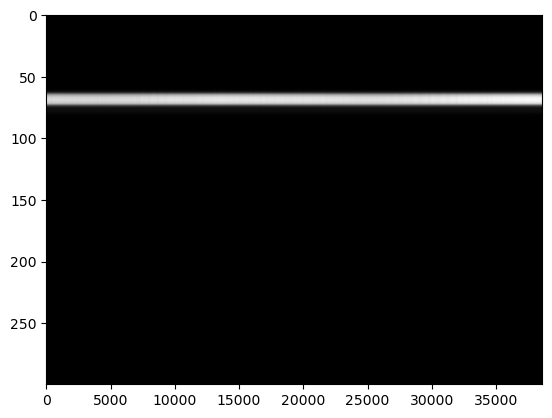

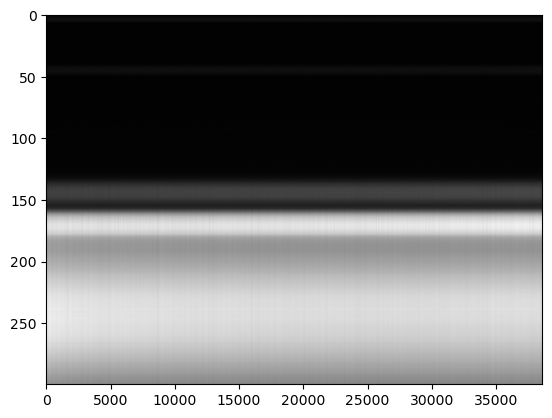

In [38]:
# Plot a spectrogram image of LCh473_F1 as a check

plt.figure()
plt.imshow(LCh_405_F1.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_473_F1.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_560_F1.T, aspect='auto', cmap='gray')
plt.show()